#### The development of a hybrid anomaly detection model begins by loading and cleaning the dataset to remove inconsistencies and irrelevant data. Proceed with selecting the most predictive features for anomaly detection. Divide the data into training and testing sets, ensuring that both contain a representative mix of anomalies and normal instances. Apply feature scaling to standardize the range of the data features, which is crucial for many modeling techniques. Fit the hybrid model, which typically integrates multiple anomaly detection methods to leverage their individual strengths. Finally, the model's effectiveness will be evaluated using precision, recall, and the F1-score, and performance will be visually assessed with a confusion matrix. This comprehensive approach ensures that the hybrid model is robust, accurate, and reliable in detecting anomalies across different data scenarios, instilling assurance in its reliability.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Precision: 0.937
Recall: 0.936
F1 Score: 0.934
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3408
           1       0.93      0.98      0.95      7028

    accuracy                           0.94     10436
   macro avg       0.94      0.91      0.92     10436
weighted avg       0.94      0.94      0.93     10436



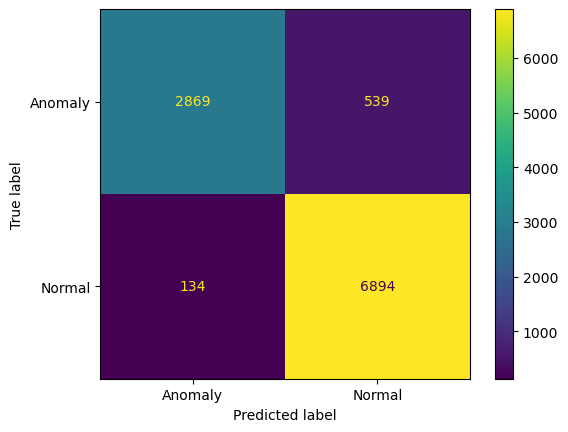

In [4]:

def hybrid_svm_iso():
    # Load the dataset
    data = pd.read_csv('US_Util_2020.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    
    data = data.drop(['zip'], axis=1)
    
#     data.info()
    X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['res_rate']
    
    data = data.dropna(axis=0, inplace=True)

    y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
    
    selector = SelectKBest(f_classif, k=4)
    X_selected = selector.fit_transform(X, y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Use SVM to identify normal data points
    svm = SVC(kernel='rbf', gamma='auto')
    svm.fit(X_train_scaled, y_train)
    svm_preds = svm.predict(X_train_scaled)
    
    # Append SVM predictions as a new feature to the scaled data
    X_train_scaled_with_pred = np.hstack((X_train_scaled, svm_preds.reshape(-1, 1)))
    
    # Filter only normal data points as identified by SVM
    normal_indices = np.where(svm_preds == 0)[0]  # Assuming '0' is normal
    X_train_normal = X_train_scaled[normal_indices]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Prepare test data by appending SVM predictions
    svm_preds_test = svm.predict(X_test_scaled)
    X_test_scaled_with_pred = np.hstack((X_test_scaled, svm_preds_test.reshape(-1, 1)))
    
    # Predict and evaluate the model on the test set using Isolation Forest
    iso_preds = iso_forest.predict(X_test_scaled_with_pred[:, :-1])  # Exclude the appended SVM predictions
    # Convert predictions to match the original label (1 for normal, -1 for anomaly)
    iso_preds = np.where(iso_preds == 1, 0, 1)  # Assuming '0' is normal, '1' is anomaly
    
    # Evaluate the final outcome from Isolation Forest
    precision = precision_score(y_test, iso_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, iso_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, iso_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    
    print(classification_report(y_test, iso_preds))
    
    
    # Use a confusion matrix for visualization of the outcome
    
    cm = confusion_matrix(y_test, iso_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

hybrid_svm_iso()